In [34]:
import pandas as pd
import numpy as np
from math import ceil

# --- Setup ---
np.random.seed(42)
total_rows = 1000
jadwal_per_hari = 24 * 2  # 24 jam * 2 kota = 48 keberangkatan per hari
jumlah_hari = total_rows // jadwal_per_hari  # agar total row mendekati 1000

# 1. Tanggal berurutan (diulang sebanyak 48 kali per hari)
tanggal = np.repeat(pd.date_range("2024-01-01", periods=jumlah_hari, freq="D"), jadwal_per_hari)

# 2. Jam keberangkatan 0:00 - 23:00, untuk setiap kota A & B
jam_range = pd.date_range("2024-01-01 00:00", "2024-01-01 23:00", freq="1H").time
jam_keberangkatan = np.tile(np.repeat(jam_range, 2), jumlah_hari)  # ulang untuk A & B

# 3. Asal kota A & B (bergantian)
asal_kota = np.tile(['A', 'B'], jumlah_hari * 24)

# 4. Jumlah keberangkatan per hari
jumlah_keberangkatan_per_hari = jadwal_per_hari

# 5. Jumlah unit per hari (dibulatkan ke atas)
jumlah_unit_per_hari = ceil((jumlah_keberangkatan_per_hari * 4) / 24)

# 6. Cost unit per hari
cost_unit_per_hari = jumlah_unit_per_hari * 300_000

# 7. Okupansi
okupansi = []
for jam in jam_keberangkatan:
    hour = int(str(jam).split(':')[0])
    if 4 <= hour <= 7 or 16 <= hour <= 19:
        okupansi.append(np.random.choice(np.arange(0.4, 1.1, 0.1)))
    else:
        okupansi.append(np.random.choice(np.arange(0.0, 0.4, 0.1)))
okupansi = np.round(okupansi, 1)

# 8. Buat DataFrame
df = pd.DataFrame({
    "tanggal": tanggal,
    "asal_kota": asal_kota,
    "jam_keberangkatan": jam_keberangkatan,
    "jumlah_unit_per_hari": jumlah_unit_per_hari,
    "cost_unit_per_hari": cost_unit_per_hari,
    "okupansi": okupansi,
})

# 9. Tambahkan jumlah jadwal per hari
df["jumlah_jadwal_perhari"] = jumlah_keberangkatan_per_hari

# 10. Hitung mean okupansi per hari
mean_okupansi_per_hari = df.groupby("tanggal")["okupansi"].transform("mean")

# 11. Hitung rasio pendapatan per cost
df["rasio_pendapatan_per_cost"] = (
    mean_okupansi_per_hari * df["jumlah_jadwal_perhari"] * 175_000 / df["cost_unit_per_hari"]
)

df.reset_index(drop=True, inplace=True)

df


C:\Users\regid\AppData\Local\Temp\ipykernel_25088\4155589489.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  jam_range = pd.date_range("2024-01-01 00:00", "2024-01-01 23:00", freq="1H").time


,tanggal,asal_kota,jam_keberangkatan,jumlah_unit_per_hari,cost_unit_per_hari,okupansi,jumlah_jadwal_perhari,rasio_pendapatan_per_cost
0,2024-01-01,A,00:00:00,8,2400000,0.2,48,1.203125
1,2024-01-01,B,00:00:00,8,2400000,0.3,48,1.203125
2,2024-01-01,A,01:00:00,8,2400000,0.0,48,1.203125
3,2024-01-01,B,01:00:00,8,2400000,0.2,48,1.203125
4,2024-01-01,A,02:00:00,8,2400000,0.2,48,1.203125
...,...,...,...,...,...,...,...,...
955,2024-01-20,B,21:00:00,8,2400000,0.1,48,1.232292
956,2024-01-20,A,22:00:00,8,2400000,0.2,48,1.232292
957,2024-01-20,B,22:00:00,8,2400000,0.0,48,1.232292
958,2024-01-20,A,23:00:00,8,2400000,0.0,48,1.232292


In [35]:
import pandas as pd
import numpy as np
from math import ceil
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor


In [36]:
df

,tanggal,asal_kota,jam_keberangkatan,jumlah_unit_per_hari,cost_unit_per_hari,okupansi,jumlah_jadwal_perhari,rasio_pendapatan_per_cost
0,2024-01-01,A,00:00:00,8,2400000,0.2,48,1.203125
1,2024-01-01,B,00:00:00,8,2400000,0.3,48,1.203125
2,2024-01-01,A,01:00:00,8,2400000,0.0,48,1.203125
3,2024-01-01,B,01:00:00,8,2400000,0.2,48,1.203125
4,2024-01-01,A,02:00:00,8,2400000,0.2,48,1.203125
...,...,...,...,...,...,...,...,...
955,2024-01-20,B,21:00:00,8,2400000,0.1,48,1.232292
956,2024-01-20,A,22:00:00,8,2400000,0.2,48,1.232292
957,2024-01-20,B,22:00:00,8,2400000,0.0,48,1.232292
958,2024-01-20,A,23:00:00,8,2400000,0.0,48,1.232292


In [37]:
from sklearn.model_selection import train_test_split


In [38]:
x = df.drop(columns='rasio_pendapatan_per_cost')
y = df['rasio_pendapatan_per_cost']

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

In [40]:
y

0      1.203125
1      1.203125
2      1.203125
3      1.203125
4      1.203125
         ...   
955    1.232292
956    1.232292
957    1.232292
958    1.232292
959    1.232292
Name: rasio_pendapatan_per_cost, Length: 960, dtype: float64

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler

In [42]:
import pandas as pd
import numpy as np

# === 1. Setup dasar ===
np.random.seed(42)
n_rows = 1000

# === 2. Buat tanggal (berurutan) ===
tanggal = pd.date_range(start="2025-01-01", periods=n_rows//40, freq="D")
tanggal = np.repeat(tanggal, 40)  # Asumsi minimal 40 jadwal per hari
tanggal = tanggal[:n_rows]  # Batasi 1000 row

# === 3. Jumlah keberangkatan per hari (random 40-60) ===
unique_dates = pd.Series(tanggal).dt.normalize().unique()
jumlah_keberangkatan_perhari = {pd.Timestamp(d): np.random.randint(40, 61) for d in unique_dates}
jumlah_keberangkatan = [jumlah_keberangkatan_perhari[pd.Timestamp(d.normalize())] for d in tanggal]

# === 4. Jam keberangkatan (acak per 30 menit sesuai jumlah keberangkatan per hari) ===
jam_list = []
for d in tanggal:
    jam_tersedia = pd.date_range("05:00", "22:00", freq="30min").strftime("%H:%M")
    jam_acak = np.random.choice(jam_tersedia, size=1)
    jam_list.append(jam_acak[0])

# === 5. Asal kota (A dan B bergantian, bulak-balik) ===
asal_kota = np.tile(['A', 'B'], n_rows // 2 + 1)[:n_rows]

# === 6. Jumlah kebutuhan unit (total keberangkatan dibagi 5) ===
jumlah_kebutuhan_unit = np.array(jumlah_keberangkatan) // 5
jumlah_kebutuhan_unit[jumlah_kebutuhan_unit == 0] = 1

# === 7. Okupansi (0.4 kelipatan 0.1 di jam sibuk, sisanya <0.4) ===
okupansi = []
for jam in jam_list:
    hour = int(jam.split(":")[0])
    if 5 <= hour <= 8 or 16 <= hour <= 20:
        okupansi.append(np.round(np.random.choice(np.arange(0.4, 1.1, 0.1)), 2))
    else:
        okupansi.append(np.round(np.random.choice(np.arange(0.1, 0.4, 0.1)), 2))

okupansi = np.array(okupansi)

# === 8. Hitung mean okupansi per hari ===
mean_okupansi_perhari = pd.Series(okupansi).groupby(pd.Series(tanggal).dt.normalize()).transform('mean')

# === 9. Rasio pendapatan per cost ===
rasio_pendapatan_per_cost = (np.array(jumlah_keberangkatan) * mean_okupansi_perhari * 175000) / (jumlah_kebutuhan_unit * 300000)

# === 10. Buat DataFrame ===
df = pd.DataFrame({
    "tanggal": tanggal,
    "jam_keberangkatan": jam_list,
    "asal_kota": asal_kota,
    "jumlah_kebutuhan_unit": jumlah_kebutuhan_unit,
    "jumlah_keberangkatan_perhari": jumlah_keberangkatan,
    "okupansi": okupansi,
    "rasio_pendapatan_per_cost": rasio_pendapatan_per_cost
})



df.head(10)


,tanggal,jam_keberangkatan,asal_kota,jumlah_kebutuhan_unit,jumlah_keberangkatan_perhari,okupansi,rasio_pendapatan_per_cost
0,2025-01-01,18:30,A,9,46,0.6,1.356574
1,2025-01-01,12:30,B,9,46,0.1,1.356574
2,2025-01-01,12:00,A,9,46,0.3,1.356574
3,2025-01-01,06:00,B,9,46,0.9,1.356574
4,2025-01-01,08:00,A,9,46,0.6,1.356574
5,2025-01-01,15:00,B,9,46,0.4,1.356574
6,2025-01-01,09:00,A,9,46,0.2,1.356574
7,2025-01-01,13:30,B,9,46,0.4,1.356574
8,2025-01-01,06:30,A,9,46,0.8,1.356574
9,2025-01-01,17:00,B,9,46,0.4,1.356574


In [43]:
import pandas as pd

# Pastikan format datetime
df["jam_keberangkatan"] = pd.to_datetime(df["jam_keberangkatan"], format="%H:%M")

# Ubah ke menit sejak 00:00
df["jam_keberangkatan_menit"] = df["jam_keberangkatan"].dt.hour * 60 + df["jam_keberangkatan"].dt.minute


In [72]:
x = df.drop(columns='rasio_pendapatan_per_cost')
y = df['rasio_pendapatan_per_cost']

In [45]:
x.drop(columns='tanggal', inplace=True)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   tanggal                       1000 non-null   datetime64[ns]
 1   jam_keberangkatan             1000 non-null   datetime64[ns]
 2   asal_kota                     1000 non-null   object        
 3   jumlah_kebutuhan_unit         1000 non-null   int32         
 4   jumlah_keberangkatan_perhari  1000 non-null   int64         
 5   okupansi                      1000 non-null   float64       
 6   rasio_pendapatan_per_cost     1000 non-null   float64       
 7   jam_keberangkatan_menit       1000 non-null   int32         
dtypes: datetime64[ns](2), float64(2), int32(2), int64(1), object(1)
memory usage: 54.8+ KB


In [47]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

In [48]:
cat_cols = x.select_dtypes(exclude='number').columns
num_cols = x.select_dtypes(include='number').columns
column_transfer = ColumnTransformer([
    ('onehot', OneHotEncoder(sparse_output=False, drop='first'), ['asal_kota']),
    ('scaling', RobustScaler(), num_cols)], verbose_feature_names_out=False).set_output(transform='pandas')

In [49]:
column_transfer.fit_transform(x_train, y_train)

,asal_kota_B,jumlah_kebutuhan_unit,jumlah_keberangkatan_perhari,okupansi,jam_keberangkatan_menit
29,1.0,-0.5,-0.4,-0.25,-0.473684
535,1.0,-1.0,-0.8,1.50,-0.947368
695,1.0,-0.5,-0.5,0.25,-0.842105
557,1.0,-1.0,-0.8,-0.50,0.789474
836,0.0,-1.0,-1.0,0.25,-0.789474
...,...,...,...,...,...
106,0.0,0.0,0.4,1.50,0.315789
270,0.0,-0.5,-0.4,0.50,-0.947368
860,0.0,0.0,0.1,0.00,0.368421
435,1.0,1.0,1.0,-0.25,-0.473684


In [50]:
base = Pipeline([('preprocesss', column_transfer), ('model', DecisionTreeRegressor(random_state=42))
])

In [51]:
base.fit(x_train, y_train)

,steps,"[('preprocesss', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('onehot', ...), ('scaling', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

dtree = DecisionTreeRegressor(random_state=42)
linreg = LinearRegression()
rf = RandomForestRegressor(random_state=42)

list_model = [dtree, linreg, rf]
rmsel = []
mael = []
msel = []
mapel = []
for i in list_model:
    base = Pipeline([('preprocesss', column_transfer), ('model', i)])
    base.fit(x_train, y_train)
    y_pred = base.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)  # Root Mean Squared Error
    rmse = root_mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmsel.append(rmse)
    mael.append(mae)
    msel.append(mse)
    mapel.append(mape)

df_cv = pd.DataFrame()
df_cv["model"] = list_model
df_cv["mae"] = mael
df_cv["mape"] = mapel
df_cv["rmse"] = rmsel
df_cv["mse"] = msel
df_cv.sort_values(["mae", "mape"], ascending=[False, False])

,model,mae,mape,rmse,mse
1,LinearRegression(),0.082567,0.058894,0.107554,0.011568
2,"(DecisionTreeRegressor(max_features=1.0, rando...",0.044980,0.033371,0.076956,0.005922
0,DecisionTreeRegressor(random_state=42),0.043991,0.032579,0.087478,0.007652


In [60]:
best_model = Pipeline([('preprocesss', column_transfer), ('model', RandomForestRegressor(random_state=42))])
best_model.fit(x, y)

,steps,"[('preprocesss', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('onehot', ...), ('scaling', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [ ]:
import numpy as np
import pandas as pd
import datetime

# Buat jumlah keberangkatan perhari (random antara 55 - 70 step 5)
jumlah_keb = np.arange(55, 70, 5)  # [55, 60, 65]
keb_unit = jumlah_keb / 5

# Buat jam keberangkatan dalam menit (misalnya 08:00 - 18:00 setiap 30 menit)
jam_keberangkatan = np.arange(480, 1080, 30)  # 480 = 08:00, 1080 = 18:00

# Buat kombinasi data baru
new_data = pd.DataFrame({
    "tanggal_ordinal": np.repeat(datetime.date(2025,1,1).toordinal(), len(jam_keberangkatan)),
    "jam_keberangkatan_menit": jam_keberangkatan,
    "asal_kota": np.random.choice(["A","B"], len(jam_keberangkatan)),
    "jumlah_kebutuhan_unit": np.random.choice(keb_unit, len(jam_keberangkatan)),
    "jumlah_keberangkatan_perhari": np.random.randint(40, 60, len(jam_keberangkatan)),
    "okupansi": np.random.choice(np.arange(0.3, 0.8, 0.1), len(jam_keberangkatan)),
    
})

print(new_data.head())


   tanggal_ordinal  jam_keberangkatan_menit asal_kota  jumlah_kebutuhan_unit  \
0           739252                      480         B                   11.0   
1           739252                      510         B                   12.0   
2           739252                      540         B                   11.0   
3           739252                      570         B                   12.0   
4           739252                      600         A                   12.0   

   jumlah_keberangkatan_perhari  okupansi  
0                            48       0.7  
1                            54       0.3  
2                            49       0.5  
3                            49       0.6  
4                            47       0.4  


In [55]:
new_data['jumlah_keberangkatan_perhari'].unique()

array([51, 44, 41, 55, 54, 43, 50, 45, 53, 57, 52])

In [62]:
# Prediksi
y_pred_new = best_model.predict(new_data)
new_data["prediksi"] = y_pred_new

# Pastikan kolom rasio sudah ada, kalau belum kita hitung
if "rasio_pendapatan_per_cost" not in new_data.columns:
    new_data["rasio_pendapatan_per_cost"] = (
        new_data["jumlah_keberangkatan_perhari"]
        * new_data["okupansi"].mean()
        * 175000 
        / (new_data["jumlah_kebutuhan_unit"] * 300000)
    )


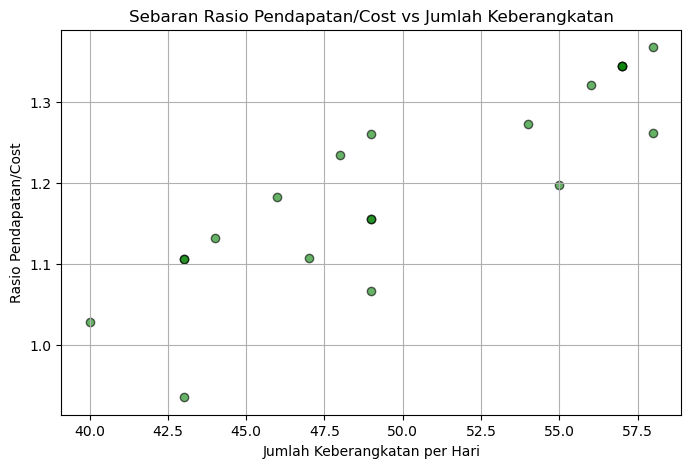

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(
    new_data["jumlah_keberangkatan_perhari"],
    new_data["rasio_pendapatan_per_cost"],
    c='green', alpha=0.6, edgecolor='k'
)

plt.title("Sebaran Rasio Pendapatan/Cost vs Jumlah Keberangkatan")
plt.xlabel("Jumlah Keberangkatan per Hari")
plt.ylabel("Rasio Pendapatan/Cost")
plt.grid(True)
plt.show()


In [58]:
y_pred_new = best_model.predict(new_data)
print("Prediksi:", y_pred_new)

Prediksi: [1.428      1.51666667 1.25052083 1.51666667 1.26145833 1.26145833
 1.51666667 1.51666667 1.51666667 1.10833333 1.39270833 1.65520833
 1.10833333 1.5219697  1.10833333 1.10833333 1.39270833 1.48020833
 1.693125   1.10833333]


In [59]:
import joblib

In [64]:
y_pred_new = best_model.predict(df)
print("Prediksi:", y_pred_new)

Prediksi: [1.380575   1.37118333 1.40734125 1.38683611 1.36883542 1.38283596
 1.37327037 1.40873261 1.36179167 1.39414074 1.36283519 1.37327037
 1.37953148 1.37848796 1.380575   1.36805278 1.37605309 1.40508029
 1.40248889 1.37587917 1.37674877 1.37118333 1.38996667 1.36874846
 1.36805278 1.38370556 1.37805316 1.39101019 1.38683611 1.36596574
 1.36777451 1.39518426 1.36579182 1.36553094 1.37666181 1.38266204
 1.37640093 1.38701003 1.37118333 1.38892315 1.50181818 1.50181818
 1.50181818 1.50181818 1.50181818 1.50181818 1.50181818 1.50181818
 1.50181818 1.50181818 1.50181818 1.50181818 1.50181818 1.50181818
 1.50181818 1.50181818 1.50181818 1.50181818 1.50181818 1.50181818
 1.50181818 1.50181818 1.50181818 1.50181818 1.50181818 1.50181818
 1.50181818 1.50181818 1.50181818 1.50181818 1.50181818 1.50181818
 1.50181818 1.50181818 1.50181818 1.50181818 1.50181818 1.50181818
 1.50181818 1.50181818 1.693125   1.693125   1.693125   1.693125
 1.693125   1.693125   1.693125   1.693125   1.693125 

In [65]:
df['rasio_pendapatan_per_cost']

0      1.356574
1      1.356574
2      1.356574
3      1.356574
4      1.356574
         ...   
995    1.405347
996    1.405347
997    1.405347
998    1.405347
999    1.405347
Name: rasio_pendapatan_per_cost, Length: 1000, dtype: float64

In [68]:
diff = y_pred_new - df['rasio_pendapatan_per_cost']
diff.describe()

count    1.000000e+03
mean     3.296606e-04
std      3.980380e-02
min     -2.367458e-01
25%     -1.066204e-02
50%     -8.881784e-16
75%      1.195833e-02
max      2.275097e-01
Name: rasio_pendapatan_per_cost, dtype: float64

In [69]:
joblib.dump(best_model, 'model_joblib.pkl')

['model_joblib.pkl']

In [73]:
pd.set_option('display.max_colwidth', None)


cat_cols = x.select_dtypes(exclude='number').columns

unique_values_df = pd.DataFrame({
    'column': cat_cols,
    'unique_values': [x[col].unique().tolist() for col in cat_cols]
})

unique_values_df

,column,unique_values
0,tanggal,"[2025-01-01 00:00:00, 2025-01-02 00:00:00, 2025-01-03 00:00:00, 2025-01-04 00:00:00, 2025-01-05 00:00:00, 2025-01-06 00:00:00, 2025-01-07 00:00:00, 2025-01-08 00:00:00, 2025-01-09 00:00:00, 2025-01-10 00:00:00, 2025-01-11 00:00:00, 2025-01-12 00:00:00, 2025-01-13 00:00:00, 2025-01-14 00:00:00, 2025-01-15 00:00:00, 2025-01-16 00:00:00, 2025-01-17 00:00:00, 2025-01-18 00:00:00, 2025-01-19 00:00:00, 2025-01-20 00:00:00, 2025-01-21 00:00:00, 2025-01-22 00:00:00, 2025-01-23 00:00:00, 2025-01-24 00:00:00, 2025-01-25 00:00:00]"
1,jam_keberangkatan,"[1900-01-01 18:30:00, 1900-01-01 12:30:00, 1900-01-01 12:00:00, 1900-01-01 06:00:00, 1900-01-01 08:00:00, 1900-01-01 15:00:00, 1900-01-01 09:00:00, 1900-01-01 13:30:00, 1900-01-01 06:30:00, 1900-01-01 17:00:00, 1900-01-01 11:30:00, 1900-01-01 17:30:00, 1900-01-01 05:30:00, 1900-01-01 14:30:00, 1900-01-01 08:30:00, 1900-01-01 22:00:00, 1900-01-01 13:00:00, 1900-01-01 07:30:00, 1900-01-01 19:00:00, 1900-01-01 21:30:00, 1900-01-01 09:30:00, 1900-01-01 20:00:00, 1900-01-01 16:00:00, 1900-01-01 16:30:00, 1900-01-01 05:00:00, 1900-01-01 10:00:00, 1900-01-01 21:00:00, 1900-01-01 07:00:00, 1900-01-01 10:30:00, 1900-01-01 15:30:00, 1900-01-01 18:00:00, 1900-01-01 11:00:00, 1900-01-01 20:30:00, 1900-01-01 19:30:00, 1900-01-01 14:00:00]"
2,asal_kota,"[A, B]"


In [76]:
pd.set_option('display.max_colwidth', None)


num_cols = x.select_dtypes(include='number').columns

unique_values_df = pd.DataFrame({
    'column': num_cols,
    'unique_values': [x[col].unique().tolist() for col in num_cols]
})

unique_values_df

,column,unique_values
0,jumlah_kebutuhan_unit,"[9, 11, 10, 12, 8]"
1,jumlah_keberangkatan_perhari,"[46, 59, 54, 50, 47, 60, 58, 43, 42, 41, 51, 45, 40, 56, 49]"
2,okupansi,"[0.6, 0.1, 0.3, 0.9, 0.4, 0.2, 0.8, 0.5, 0.7, 1.0]"
3,jam_keberangkatan_menit,"[1110, 750, 720, 360, 480, 900, 540, 810, 390, 1020, 690, 1050, 330, 870, 510, 1320, 780, 450, 1140, 1290, 570, 1200, 960, 990, 300, 600, 1260, 420, 630, 930, 1080, 660, 1230, 1170, 840]"
